In [1]:
from os import chdir
chdir('/Users/lananhnguyen/Desktop/thesis')
from packages.load import *

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns 

import statsmodels.tsa.stattools as ts
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from sklearn.model_selection import TimeSeriesSplit


In [84]:
def load_excel(file_path, name, sheet_name = 'Sheet 1', skiprows = 8):
    data = pd.read_excel(file_path, sheet_name=sheet_name, skiprows=skiprows)
    df = data.iloc[1, :].to_frame().reset_index()
    df.columns = df.iloc[0]
    df = df[1:]
    df.rename(columns= {'TIME': 'date', 'Germany': name}, inplace=True)
    df['date'] = pd.to_datetime(df['date'], format ='%Y-%m')
    print(f"Data length: {df.shape[0]} rows from {df.iloc[0, 0]} to {df.iloc[-1, 0]}")
    df.set_index('date', inplace=True)
    print(df.head(5))
    return df

def data_viz(df, title):
    plt.figure(figsize = (12, 4))
    plt.plot(df)
    plt.title(title)
    plt.show()

def transform_yoy_rate(df):
    df.loc[:, 'last_y'] = df.iloc[:, 0].shift(12)
    df.loc[:, 'yoy_rate'] = (df.iloc[:, 0]/df.loc[:, 'last_y'] - 1) * 100
    df = df.dropna(subset='yoy_rate')
    return df['yoy_rate']


def plots(data, lags=None):
    plt.figure(figsize=(15, 8))
    layout = (2, 1)
    acf  = plt.subplot2grid(layout, (0, 0))
    pacf = plt.subplot2grid(layout, (1, 0))
    
    plot_acf(data, lags=lags, ax=acf, zero=False)
    plot_pacf(data, lags=lags, ax=pacf, zero = False)
    sns.despine()
    plt.tight_layout()

def dftest(timeseries):
    dftest = ts.adfuller(timeseries,) #call function adfuller 
    dfoutput = pd.Series(dftest[0:4],  
                         index=['Test Statistic','p-value','Lags Used','Observations Used'])
    # display first 4 values with its name
    print(dfoutput)

    if dfoutput['p-value'] < 0.05:
        print('Time series is stationary!')
    else:
        print('Time series is not stationary!')
    


## Load and clean data:
Since we have covid period and it can mess with our data, we'll do:
split out-of-sampple forcasting into 3 periods: precovid, in covid and after covid.

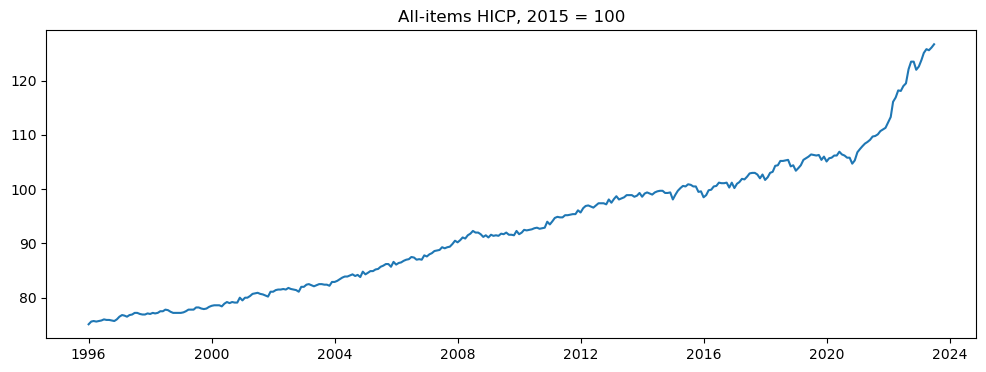

In [45]:
headline = load_excel('data/hicp_all.xlsx', 'hicp_all')
data_viz(headline, title= 'All-items HICP, 2015 = 100')

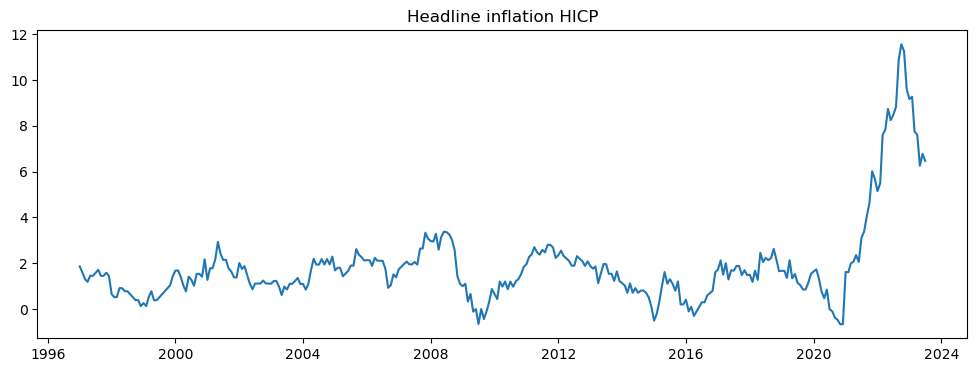

In [68]:
head_inf = transform_yoy_rate(headline)
data_viz(head_inf, title= 'Headline inflation HICP')

### test for autocorr and model:

In [72]:
dftest(head_inf)

Test Statistic        -3.198781
p-value                0.020055
Lags Used             14.000000
Observations Used    304.000000
dtype: float64
Time series is stationary!


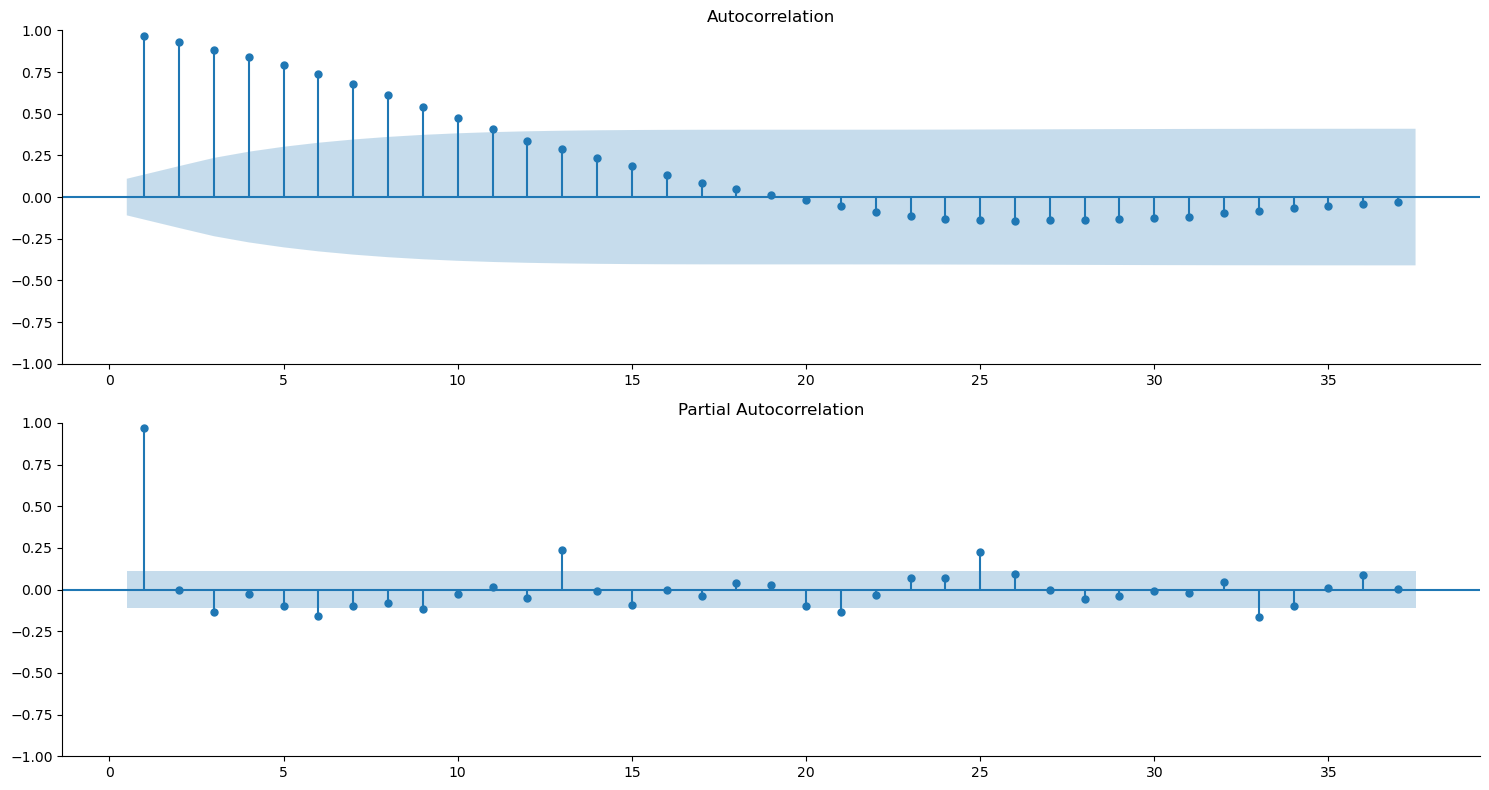

In [85]:
plots(head_inf, lags = 37)

ACF is initially large, then decays gradually to zero, then switch to be negative.
p = 1, 13, 25, 37,... have large PACF -> annual seasonality.

Also I'll split the data so to have out-of-sample forecast, and there's covid time, so I will split like:
training data: 1/1998-12/2015
test 1: 1/2016 - 12/2019 - precovid
test 2: 2020-2021 - during covid
test 3: 2022 - after covid and ukrain war and energy spike

In [76]:
head_inf_train = head_inf[head_inf.index <= '2015-12-31']

## Model:

In [77]:
#from pyramid.arima import auto_arima
stepwise_model = pm.auto_arima(head_inf_train, 
                            start_p=1, start_q=0,
                           max_p=12, max_q=0, m=12,
                           start_P=1, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,
                            information_criterion='bic') 
print(stepwise_model.bic())

Performing stepwise search to minimize bic
 ARIMA(1,0,0)(1,1,1)[12] intercept   : BIC=inf, Time=1.83 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : BIC=653.292, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : BIC=290.267, Time=0.49 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : BIC=inf, Time=0.80 sec
 ARIMA(0,0,0)(0,1,0)[12]             : BIC=648.316, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : BIC=355.334, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : BIC=228.659, Time=1.21 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : BIC=inf, Time=3.70 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : BIC=595.736, Time=0.62 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : BIC=230.600, Time=2.40 sec
 ARIMA(1,0,0)(2,1,0)[12]             : BIC=223.426, Time=0.55 sec
 ARIMA(1,0,0)(1,1,0)[12]             : BIC=285.037, Time=0.17 sec
 ARIMA(1,0,0)(2,1,1)[12]             : BIC=inf, Time=2.80 sec
 ARIMA(1,0,0)(1,1,1)[12]             : BIC=inf, Time=2.04 sec
 ARIMA(0,0,0)(2,1,0)[12]             : BIC=590.447, T

I tried with both AIC and BIC, same results.

In [22]:
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order
print('order: ',order)
print('seasonal order: ',seasonal_order)

order:  (1, 0, 0)
seasonal order:  (2, 1, 0, 12)


In [23]:
sar = SARIMAX(headline_train, 
                order=order,
                seasonal_order=seasonal_order,
                 trend ='n').fit()
sar.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04946D+00    |proj g|=  5.68868D-01


 This problem is unconstrained.



At iterate    5    f=  8.29922D-01    |proj g|=  4.54265D-02

At iterate   10    f=  8.20701D-01    |proj g|=  2.67178D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     18      1     0     0   5.954D-05   8.207D-01
  F =  0.82068406157237361     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                 s2   No. Observations:                  216
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -177.268
Date:                            Mon, 15 Jan 2024   AIC                            362.536
Time:                                    17:05:47   BIC                            375.808
Sample:                                01-31-1998   HQIC                           367.904
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9200      0.026     35.350      0.000       0.869       0.971
ar.S.L12      -1.0794      0.049    -22.245      0.000      -1.174      -0.984
ar.S.L24      -0.6224      0.053    -11.642      0.000      -0.727      -0.518
sigma2         0.3020      0.026     11.683      0.000       0.251       0.353
===================================================================================
Ljung-Box (L1) (Q):                   3.62   Jarque-Bera (JB):                10.39
Prob(Q):                              0.06   Prob(JB):                         0.01
Heteroskedasticity (H):               1.22   Skew:                            -0.39
Prob(H) (two-sided):                  0.41   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/lananhnguyen/anaconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


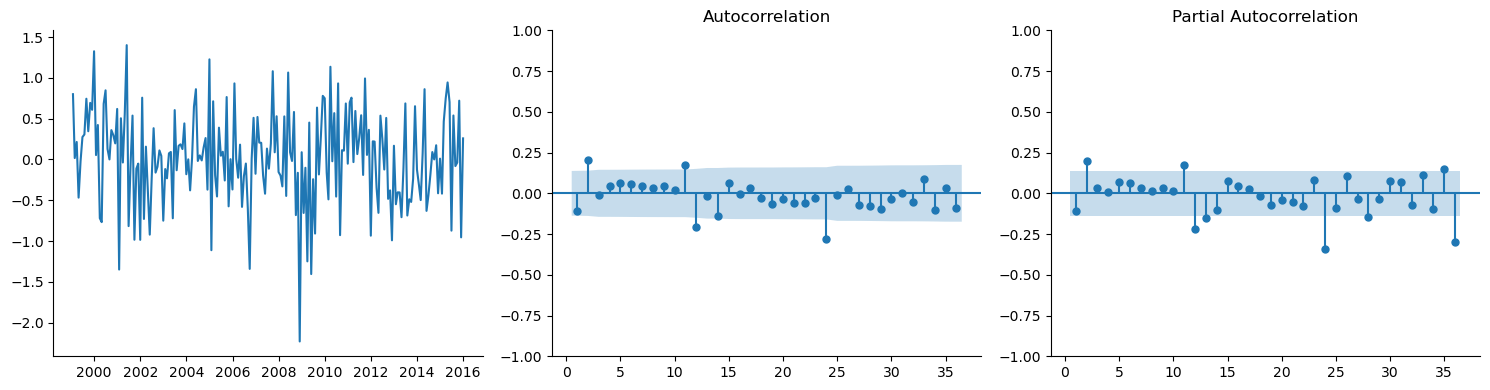

In [24]:
#plot the residuals

plots(sar.resid[sar.loglikelihood_burn:], lags=36);

It makes sense that the residuals are not white noise and still autocorrelated, the reason is that the columns having missing values are dropped.

Now let's do out-of-sample forecast and calculate RMSE. 

## Forecast:
### Recursive Approach:
We apply the optimised model but adding more data recursively.

In [25]:
T = len(headline_train)
N = len(headline_test)
horizons = [1, 2, 3] # horizon

# Create empty lists to store the forecasts
forecast_df = pd.DataFrame()

# Iterate through the time series data
for h in horizons:
    forecasts = []    
    for i in range(1, N+1):
    
        # Define the expanding window training set
        train_data = headline_yoy[:T+i-h]
        print(f'Horizon {h}, step {i}')

        # Create and fit the SARIMAX model
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order, trend='n')
        model_fit = model.fit(disp = False)
    
        # Forecast h step ahead
        pred = model_fit.forecast(steps =h)
        print('Prediction: ', pred)
        forecasts.append(pred[-1])
    # Assign the forecasted values to a new column in the DataFrame
    forecast_df[f'Horizon_{h}'] = forecasts
forecast_df['Real_obs'] = headline_test.values
forecast_df.set_index(headline_test.index, inplace = True)

Horizon 1, step 1
Prediction:  2016-01-31   -0.102466
Freq: M, dtype: float64
Horizon 1, step 2
Prediction:  2016-02-29    0.566975
Freq: M, dtype: float64
Horizon 1, step 3
Prediction:  2016-03-31    0.028438
Freq: M, dtype: float64
Horizon 1, step 4
Prediction:  2016-04-30   -0.153772
Freq: M, dtype: float64
Horizon 1, step 5
Prediction:  2016-05-31   -1.382254
Freq: M, dtype: float64
Horizon 1, step 6
Prediction:  2016-06-30   -1.256929
Freq: M, dtype: float64
Horizon 1, step 7
Prediction:  2016-07-31   -1.083964
Freq: M, dtype: float64
Horizon 1, step 8
Prediction:  2016-08-31   -1.239831
Freq: M, dtype: float64
Horizon 1, step 9
Prediction:  2016-09-30   -0.713245
Freq: M, dtype: float64
Horizon 1, step 10
Prediction:  2016-10-31   -0.329355
Freq: M, dtype: float64
Horizon 1, step 11
Prediction:  2016-11-30   -0.344473
Freq: M, dtype: float64
Horizon 1, step 12
Prediction:  2016-12-31    0.068424
Freq: M, dtype: float64
Horizon 1, step 13
Prediction:  2017-01-31    0.969004
Freq: 

In [26]:
for h in horizons:
    forecast_df[f'Error_horizon_{h}'] = forecast_df['Real_obs'] - forecast_df[f'Horizon_{h}']
forecast_df.head()

,Horizon_1,Horizon_2,Horizon_3,Real_obs,Error_horizon_1,Error_horizon_2,Error_horizon_3
date,,,,,,,
2016-01-31,-0.102466,-0.342116,0.488911,0.9,1.002466,1.242116,0.411089
2016-02-29,0.566975,-0.356708,-0.576232,0.1,-0.466975,0.456708,0.676232
2016-03-31,0.028438,0.460768,-0.386975,-0.2,-0.228438,-0.660768,0.186975
2016-04-30,-0.153772,0.055619,0.457336,-1.3,-1.146228,-1.355619,-1.757336
2016-05-31,-1.382254,-0.339390,-0.144027,-1.7,-0.317746,-1.360610,-1.555973


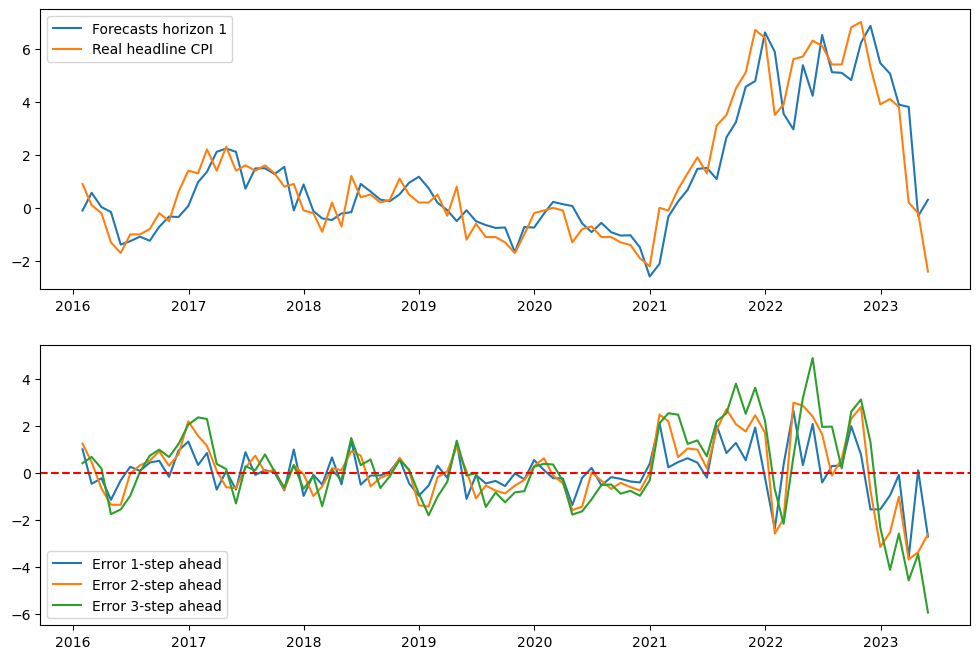

In [39]:
plt.figure(figsize = (12, 8))
plt.subplot(211)
plt.plot(forecast_df.index, forecast_df['Horizon_1'], label = 'Forecasts horizon 1')
plt.plot(forecast_df['Real_obs'], label = 'Real headline CPI')
plt.legend()

plt.subplot(212)
plt.plot(forecast_df['Error_horizon_1'], label = 'Error 1-step ahead')
plt.plot(forecast_df['Error_horizon_2'], label = 'Error 2-step ahead')
plt.plot(forecast_df['Error_horizon_3'], label = 'Error 3-step ahead')

plt.axhline(y = 0, color = 'red', linestyle = '--')
plt.legend()
plt.show()


We can see the horizon 1 is the delayed results of CPI

test 1: 1/2016 - 12/2019 - precovid
test 2: 2020-2021 - during covid
test 3: 2022 - after covid and war and energy spike

In [47]:
# Cut into test set and calculate the avg of error during different periods:

pre_covid = '2019-12-31'
end_covid = '2021-12-31'

# Define custom date ranges
custom_date_ranges = [
    ('01-01-2016 to 31-12-2019', forecast_df.index < pre_covid),
    ('01-01-2020 to 31-12-2021', (forecast_df.index >= pre_covid) & (forecast_df.index < end_covid)),
    ('01-01-2022 to 2023', forecast_df.index >= end_covid)
]

# Add a new column for custom date ranges
forecast_df['Date Range'] = pd.Categorical([label for label, condition in custom_date_ranges for _ in condition if _])
pivot_table = forecast_df.pivot_table(index='Date Range', values=['Error_horizon_1',
       'Error_horizon_2', 'Error_horizon_3'], aggfunc='mean')
pivot_table


,Error_horizon_1,Error_horizon_2,Error_horizon_3
Date Range,,,
01-01-2016 to 31-12-2019,-0.006392,-0.001096,-0.013318
01-01-2020 to 31-12-2021,0.321465,0.537849,0.718480
01-01-2022 to 2023,-0.253519,-0.248211,-0.208814


### Non-recursive approach: 
We'll use cross-validation:

In [28]:
# Cut it out into three different periods, the target is the next 3 months:


